In [1]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Conv2DTranspose, Input, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

# visualization
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
# loss fn
def ssim(input_img, output_img):
    return 1 - tf.reduce_mean(tf.image.ssim(input_img, tf.cast(output_img, tf.float64), max_val=1))


Dataset split: 60000 train rows 60000 test rows


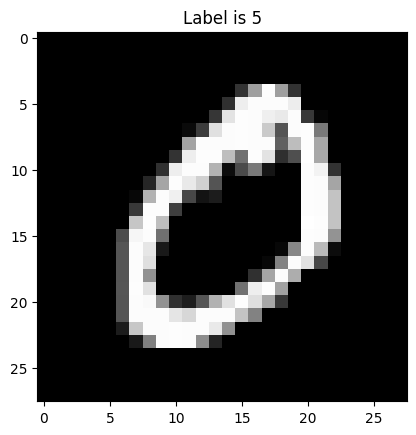

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Dataset split: {len(x_train.data)} train rows",
          f"{len(y_train.data)} test rows")

point = np.array(x_train[0], dtype='float')
point = point.reshape((28, 28))
plt.title('Label is {label}'.format(label=y_train[0]))
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [4]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

labels = len(np.unique(y_train))

y_train_categorical = to_categorical(y_train, num_classes=labels)
y_test_categorical = to_categorical(y_test, num_classes=labels)

In [5]:
def rounded_accuracy(y_true, y_pred):
    return binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# stacked encoder / decoder
stacked_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation="relu"),
    Dense(30, activation="relu"),
])

stacked_decoder = Sequential([
    Dense(100, activation="relu", input_shape=[30]),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])

In [8]:
# preparing stacked autoencoder
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

In [9]:
# compile
stacked_ae.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=1.5), metrics=['mae'])

In [10]:
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [11]:
# history
history = stacked_ae.fit(x_train, x_train, epochs=12, batch_size=64, validation_data=(x_test, x_test), shuffle=True)

Epoch 1/12
938/938 [==============================] - 3s 3ms/step - loss: 0.2285 - mae: 0.1284 - val_loss: 0.1730 - val_mae: 0.0903
Epoch 2/12
938/938 [==============================] - 2s 3ms/step - loss: 0.1565 - mae: 0.0782 - val_loss: 0.1404 - val_mae: 0.0682
Epoch 3/12
938/938 [==============================] - 2s 2ms/step - loss: 0.1330 - mae: 0.0615 - val_loss: 0.1257 - val_mae: 0.0570
Epoch 4/12
938/938 [==============================] - 2s 3ms/step - loss: 0.1229 - mae: 0.0544 - val_loss: 0.1176 - val_mae: 0.0513
Epoch 5/12
938/938 [==============================] - 3s 3ms/step - loss: 0.1164 - mae: 0.0500 - val_loss: 0.1137 - val_mae: 0.0479
Epoch 6/12
938/938 [==============================] - 3s 3ms/step - loss: 0.1116 - mae: 0.0466 - val_loss: 0.1083 - val_mae: 0.0449
Epoch 7/12
938/938 [==============================] - 3s 3ms/step - loss: 0.1081 - mae: 0.0442 - val_loss: 0.1085 - val_mae: 0.0445
Epoch 8/12
938/938 [==============================] - 3s 3ms/step - loss: 0.

In [12]:
# summary
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163814 (639.90 KB)
Trainable params: 163814 (639.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
stacked_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81530 (318.48 KB)
Trainable params: 81530 (318.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
stacked_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82284 (321.42 KB)
Trainable params: 82284 (321.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


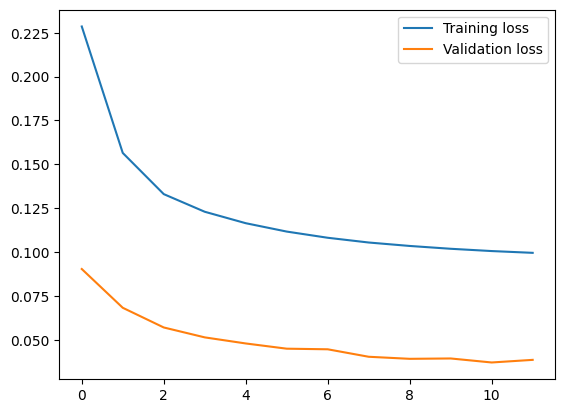

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_mae'], label='Validation loss')
plt.legend()

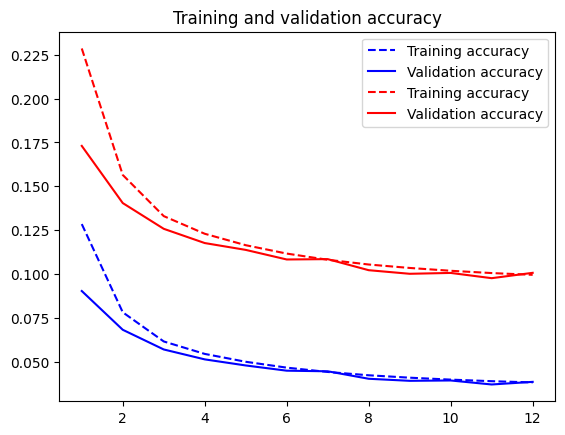

In [16]:
def history_plot(history):
    epochs = range(1, len(history['mae']) + 1)
    plt.plot(epochs, history['mae'], '--', label='Training accuracy', color='b')
    plt.plot(epochs, history['val_mae'], '-', label='Validation accuracy', color='b')
    plt.plot(epochs, history['loss'], '--', label='Training accuracy', color='r')
    plt.plot(epochs, history['val_loss'], '-', label='Validation accuracy', color='r')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

history_plot(history.history)

313/313 [==============================] - 0s 1ms/step
The prediction loss threshold for 2% of outliers is 0.14


c:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

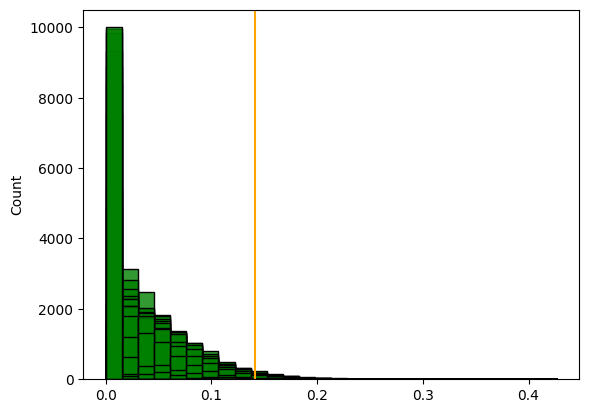

In [17]:
# predicting anomalies and outliers
prediction = stacked_ae.predict(x_test)

# get the mean absolute error between actual and reconstruction / prediction
prediction_loss = mae(prediction, x_test)

# check prediction loss threshold for outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# visualize the threshold
sn.histplot(prediction_loss, bins=28, alpha=0.8, palette=['green'], legend=None)
plt.axvline(x=loss_threshold, color='orange')

In [18]:
# check the model performance at 2% threshold
print(loss_threshold)

threshold_prediction = [0 if np.asarray(i).any() < loss_threshold else 1 for i in prediction_loss]
print(threshold_prediction)
# # check the prediction performance

0.14144585609436036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [19]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [20]:
def show_reconstructions(model, images=x_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 15ms/step


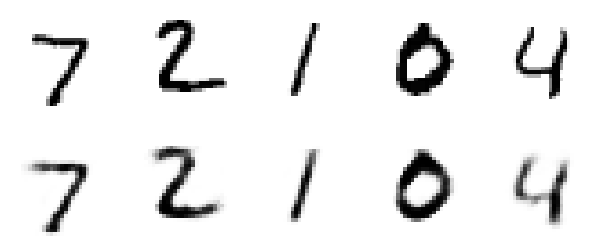

In [21]:
show_reconstructions(stacked_ae)

In [22]:
x_test_compressed = stacked_encoder.predict(x_test)
print(x_test_compressed)
tsne = TSNE()

x_valid_2d = tsne.fit_transform(x_test_compressed)
x_valid_2d = (x_valid_2d - x_valid_2d.min()) / (x_valid_2d.max() - x_valid_2d.min())

313/313 [==============================] - 0s 776us/step
[[12.36707     6.2866907   5.876757   ... 11.170039    9.08483
   3.6352065 ]
 [ 0.24547051  3.5004337   3.218288   ...  5.166692    2.8689456
   3.4920304 ]
 [ 3.1032507   1.0348725   7.480136   ...  7.7333765   3.3596833
   3.5250723 ]
 ...
 [10.5314045   9.459822    4.3633857  ...  4.992199   10.396213
   8.259422  ]
 [ 9.94368     8.208467    8.417339   ...  4.145613   11.052342
   5.6074615 ]
 [ 2.5308344   4.5013957   7.9581895  ... 10.600551    9.987932
   6.0373693 ]]


[[0.14143498 0.54886115]
 [0.47919813 0.2540037 ]
 [0.21575667 0.29651982]
 ...
 [0.40287802 0.647692  ]
 [0.657204   0.7353542 ]
 [0.8937901  0.2751667 ]]


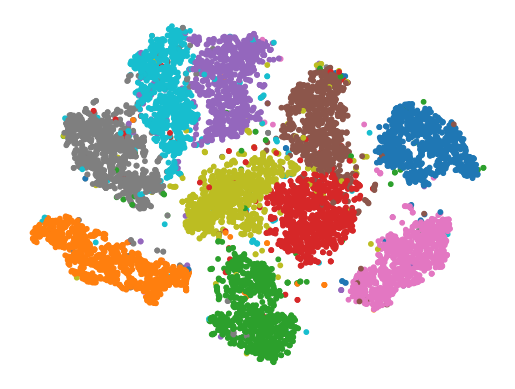

In [23]:
print(x_valid_2d)
plt.scatter(x_valid_2d[:, 0], x_valid_2d[:, 1], c=y_test, s=10, cmap="tab10")
plt.axis("off")
plt.show()

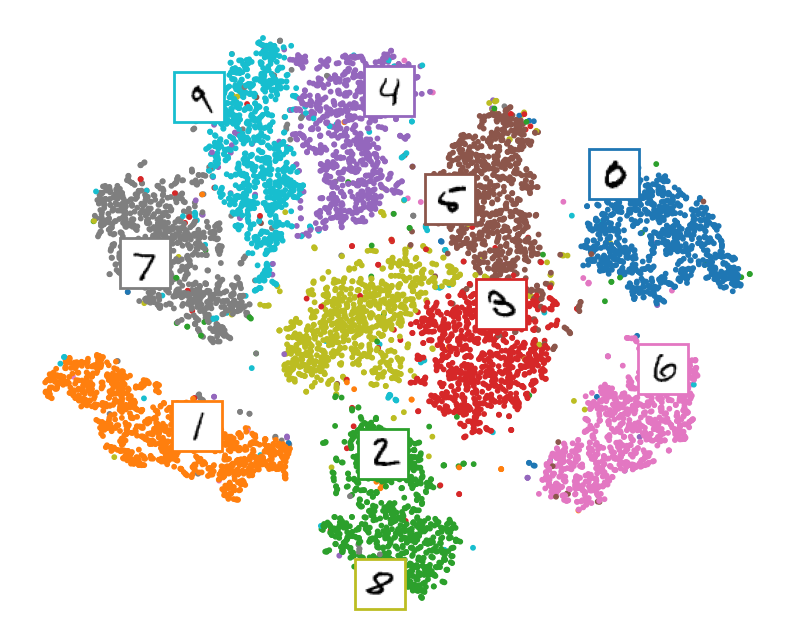

In [25]:
import matplotlib as mpl
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(x_valid_2d[:, 0], x_valid_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
used_labels = []
for index, position in enumerate(x_valid_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if y_test[index] not in used_labels:
        if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2}
            )
            plt.gca().add_artist(imagebox)
            used_labels.append(y_test[index])
plt.axis("off")
plt.show()